# <center>Bibliotecas utilizadas</center>

In [1]:
from fastkan import FastKAN as KAN

import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import *

# <center>Pré-processamento dos dados</center>

In [2]:
dataset_path = 'dataset_teste3'

In [3]:
transform = transforms.Compose(
    [transforms.Resize(size = (164,164)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5], std=[0.5])
    ]
)

In [4]:
dataset = datasets.ImageFolder(dataset_path, transform = transform)

In [5]:
print("Informações sobre o Dataset: \n\n", dataset)
print("\nRótulos: ", dataset.classes)

Informações sobre o Dataset: 

 Dataset ImageFolder
    Number of datapoints: 5000
    Root location: dataset_teste3
    StandardTransform
Transform: Compose(
               Resize(size=(164, 164), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

Rótulos:  ['NORMAL', 'PNEUMONIA', 'TUBERCULOSE']


In [6]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [7]:
train_loader = DataLoader(train_dataset, batch_size=28, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=30, shuffle=False)

# <center>Implementação da arquitetura *fastKAN*</center>

In [8]:
model = KAN([164*164*3, 164, 64, 3])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FastKAN(
  (layers): ModuleList(
    (0): FastKANLayer(
      (layernorm): LayerNorm((80688,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=645504, out_features=164, bias=False)
      (base_linear): Linear(in_features=80688, out_features=164, bias=True)
    )
    (1): FastKANLayer(
      (layernorm): LayerNorm((164,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=1312, out_features=64, bias=False)
      (base_linear): Linear(in_features=164, out_features=64, bias=True)
    )
    (2): FastKANLayer(
      (layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=512, out_features=3, bias=False)
      (base_linear): Linear(in_features=64, out_features=3, bias=True)
    )
  )
)

In [9]:
num_epoch = 250
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [10]:
train_losses = []
train_acc = []

training_start_time = time.time()

for epoch in range(num_epoch):
    model.train()
    running_train_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.view(-1, 164*164*3).to(device)
        labels = labels.to(device)
    
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)

    _, predicted = torch.max(outputs.data, 1)

    acc = accuracy_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy())
    train_acc.append(acc)

    print(f"Época {epoch + 1}/{num_epoch} - Perda no treinamento: {train_loss:.6f} - Acurácia: {acc:.6f}")

training_time = time.time() - training_start_time
print(f"Tempo total de treinamento: {training_time:.2f} segundos")

Época 1/250 - Perda no treinamento: 1.620491 - Acurácia: 0.928571
Época 2/250 - Perda no treinamento: 0.340174 - Acurácia: 0.928571
Época 3/250 - Perda no treinamento: 0.105781 - Acurácia: 1.000000
Época 4/250 - Perda no treinamento: 0.182322 - Acurácia: 1.000000
Época 5/250 - Perda no treinamento: 0.135062 - Acurácia: 1.000000
Época 6/250 - Perda no treinamento: 0.047927 - Acurácia: 1.000000
Época 7/250 - Perda no treinamento: 0.038669 - Acurácia: 1.000000
Época 8/250 - Perda no treinamento: 0.026439 - Acurácia: 1.000000
Época 9/250 - Perda no treinamento: 0.049650 - Acurácia: 1.000000
Época 10/250 - Perda no treinamento: 0.018120 - Acurácia: 1.000000
Época 11/250 - Perda no treinamento: 0.050157 - Acurácia: 0.928571
Época 12/250 - Perda no treinamento: 0.060855 - Acurácia: 1.000000
Época 13/250 - Perda no treinamento: 0.017923 - Acurácia: 1.000000
Época 14/250 - Perda no treinamento: 0.020409 - Acurácia: 1.000000
Época 15/250 - Perda no treinamento: 0.016343 - Acurácia: 1.000000
Époc

Text(0.5, 0.98, 'Treinamento')

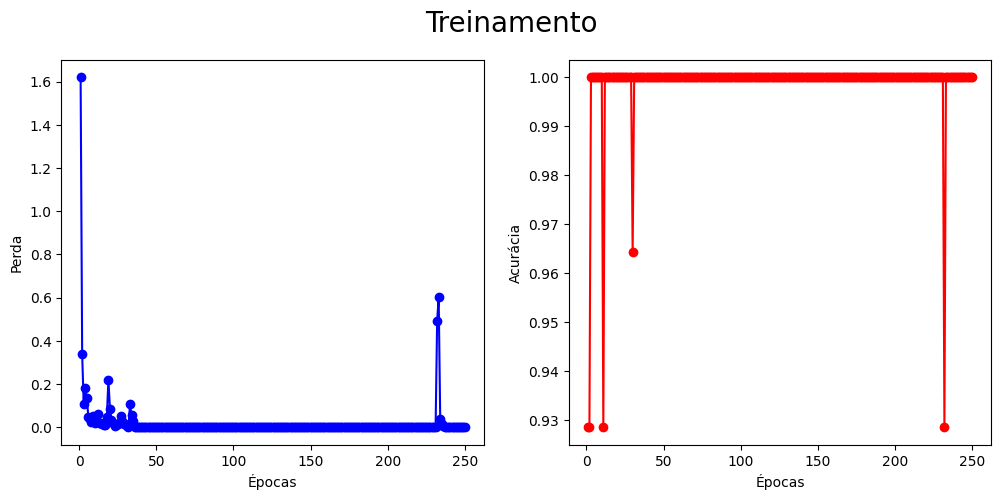

In [11]:
epochs = range(1, num_epoch + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-')
plt.xlabel('Épocas')
plt.ylabel('Perda')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'ro-')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

plt.suptitle("Treinamento", fontsize = 20)

In [12]:
rot_array = []
predt_array = []

model.eval()
    
with torch.no_grad():
        
    for images, labels in test_loader:
        images = images.view(-1, 164*164*3).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        rot_array.extend(labels.cpu().detach().numpy())
        predt_array.extend(predicted.cpu().detach().numpy())
        
print("!!!Teste finalizado!!!")

!!!Teste finalizado!!!


# <center>Métricas de avaliação</center>

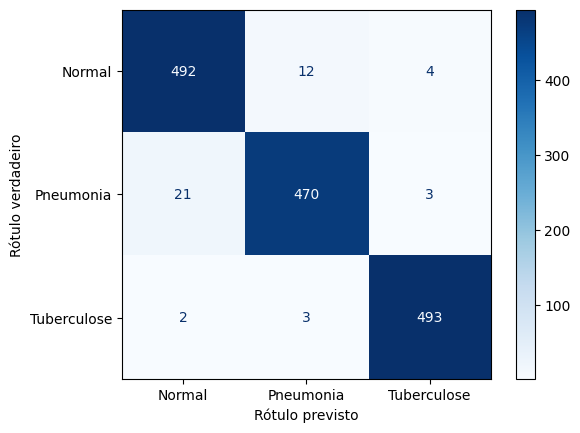

In [13]:
cm = confusion_matrix(rot_array, predt_array)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia', 'Tuberculose'])
disp.plot(cmap=plt.cm.Blues)

plt.xlabel('Rótulo previsto')
plt.ylabel('Rótulo verdadeiro')
plt.show()

In [14]:
acc = accuracy_score(rot_array, predt_array)
print(f"Acurácia: {acc * 100 :.2f}%")

Acurácia: 97.00%


In [15]:
precision = precision_score(rot_array, predt_array, average='weighted')
print(f"Precisão: {precision * 100 :.2f}%")

Precisão: 97.00%


In [16]:
recall = recall_score(rot_array, predt_array, average='weighted')
print(f"Recall: {recall * 100 :.2f}%")

Recall: 97.00%


In [17]:
f1 = f1_score(rot_array, predt_array, average='weighted')
print(f"F1 Score: {f1 * 100 :.2f}%")

F1 Score: 97.00%
